<center>
  <h1><b>PGM Project : Capturing label characteristics in VAEs</b></h1>
  <br>
  22 / 12 / 2023
  <br>
  <br>
  <b>Students name:</b>  Biel & David & Aissa
</center>


# Set Up

Import all the necessary libraries and modules that the notebook will use.

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split,Dataset
from torchvision import  transforms, utils
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torchvision.transforms.functional import to_pil_image
import torchvision.utils as vutils
from torch.distributions import Normal
import torch.distributions as dist
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
import zipfile
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

This cell is used to mount Google Drive to the Colab environment. Mounting Google Drive allows the notebook to access and store files directly from/to Google Drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

This cell is dedicated to extracting the CelebA dataset from a zip file, which is a large-scale face attributes dataset with diverse and complex annotations.

In [ ]:
zip_path = '/content/drive/MyDrive/PGM/ccvae/celeba/img_align_celeba.zip'
extract_to_dir = '/content/drive/MyDrive/PGM/'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)


This cell defines a `CustomDataset` class to handling and preprocessing of the CelebA dataset for model training and evaluation.





In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, attribute_file, transform=None, selected_attributes=None):
        self.image_folder = image_folder
        self.attribute_file = attribute_file
        self.transform = transform
        self.selected_attributes = selected_attributes

        # Read attribute file
        self.data = []
        with open(attribute_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip().split()
                image_name = line[0]
                attributes = list(map(int, line[1:]))
                # Map {-1, 1} to {0, 1}
                attributes = [(attr + 1) // 2 for attr in attributes]
                self.data.append((image_name, attributes))

    def __len__(self):
        #Lenght of the data set
        return len(self.data)

    def __getitem__(self, index):

        image_name, attributes = self.data[index]
        image_path = os.path.join(self.image_folder, image_name)
        image = Image.open(image_path).convert('RGB')

        #Apply the transformation to images
        if self.transform:
            image = self.transform(image)

        # Extract only the selected attributes
        if self.selected_attributes:
            attributes = [attributes[i] for i in self.selected_attributes]
        return image, attributes

# Selected Attributes

In this cell, we define two lists of attribute labels from the CelebA dataset:
- `CELEBA_LABELS`: It includes all the attribute labels available in the dataset, representing wide range of facial characteristics.
- `CELEBA_EASY_LABELS`: A subset of selected attributes that are particularly interested for the model analysis.

In [ ]:
#Attributes of the CELEBA dataset
CELEBA_LABELS = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', \
                 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', \
                 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', \
                'Wearing_Necklace', 'Wearing_Necktie', 'Young']
#The selected attributes
CELEBA_EASY_LABELS = ['Arched_Eyebrows', 'Bags_Under_Eyes', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Eyeglasses', 'Heavy_Makeup', 'Male', \
                      'No_Beard', 'Pale_Skin', 'Receding_Hairline', 'Smiling', 'Wavy_Hair', 'Wearing_Necktie', 'Young']

# Compute the indices of the selected attributes
selected_indices = [CELEBA_LABELS.index(attr) for attr in CELEBA_EASY_LABELS]

# Define a Data Loader

This cell prepares the CelebA data loaders, that provide data for model training and evaluation. There are three dataloaders (train, valid, test), according to the split information provided in 'list_eval_partition.txt'.


In [ ]:
#list_eval_partition path
split_file = '/content/drive/MyDrive/PGM/ccvae/celeba/list_eval_partition.txt'
#img_align_celeba path
image_folder = '/content/drive/MyDrive/PGM/img_align_celeba'
#list_attr_celeba path
attribute_file = '/content/drive/MyDrive/PGM/ccvae/list_attr_celeba_modified.txt'

# Transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((64, 64)), #image shape = 3x64x64
    transforms.ToTensor(),
])

# split_map of celeba dataset introduced in list_eval_partition.txt
split_map = {
    "train": 0,
    "valid": 1,
    "test": 2,
    "all": None,
}

# Read list_eval_partition.txt
with open(split_file, 'r') as f:
    lines = f.readlines()

#Intilize a dictionary for splitting the dataset
file_split_map = {}

#Loop through all the images
for line in lines:
    #split the image_index.png and the split_map atributed to that image : 00001.png 0
    file_name, split_label = line.strip().split()
    split_label = int(split_label)

    #Fill the dic
    file_split_map[file_name] = split_label

# Separate the data set into train, valid, and test sets as introduced in list_eval_partition.txt
train_files = [file_name for file_name, split_label in file_split_map.items() if split_label == split_map["train"]]
valid_files = [file_name for file_name, split_label in file_split_map.items() if split_label == split_map["valid"]]
test_files = [file_name for file_name, split_label in file_split_map.items() if split_label == split_map["test"]]

# Initialize a CustomDataset for each split : train, valid, and test sets
train_dataset = Subset(CustomDataset(image_folder, attribute_file, transform,selected_indices), [int(os.path.splitext(f)[0]) for f in train_files])
valid_dataset = Subset(CustomDataset(image_folder, attribute_file, transform,selected_indices), [int(os.path.splitext(f)[0]) for f in valid_files])
test_dataset = Subset(CustomDataset(image_folder, attribute_file, transform,selected_indices), [int(os.path.splitext(f)[0]) for f in test_files])

# Define dataloaders parameters
batch_size=200
num_workers=4

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)

print(f"The number for train images is : {len(train_loader)*batch_size}")
print(f"The number for validation images is : {len(valid_loader)*batch_size}")
print(f"The number for test images is : {len(test_loader)*batch_size}")

The number for train images is : 162800
The number for validation images is : 20000
The number for test images is : 20000


# Visualizing CelebA

Display a batch of images from the training set to visualize what the CelebA dataset looks like after preprocessing.

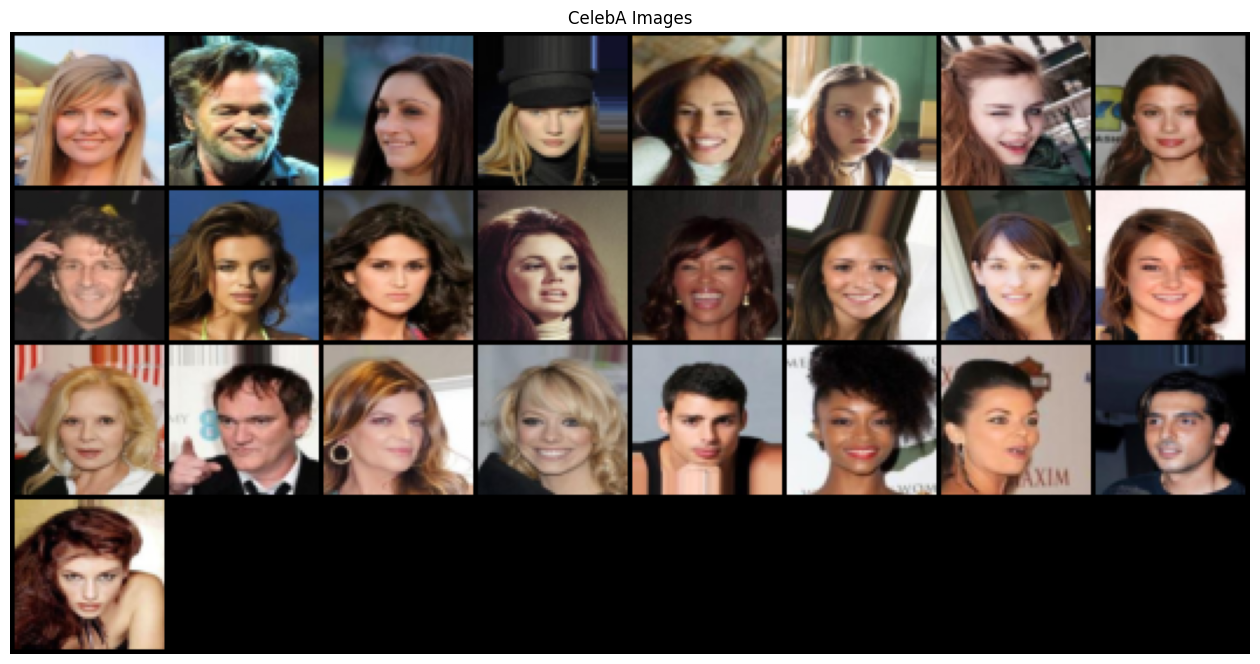

In [ ]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("CelebA Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:25], padding=2, normalize=True),(1,2,0)))

# Prior
This cell performs an analysis to compute the average presence of each attribute in the CelebA training dataset. This average will give the prior distribution p(y) of the data, that will be used by the CCVAE.


In [9]:
# Initialize attribute_sum to store the sum and count of each attribute
attribute_sum = [0] * len(CELEBA_EASY_LABELS)

# Iterate through the train data loader
for images, batch_attributes in train_loader:

    # Loop through each batch of attributes
    for i, value in enumerate(batch_attributes):
        attribute_sum[i] += sum(value)

#Calcualate the average of each attribute
attribute_average = [s / len(train_dataset) for s in attribute_sum]

# Convert attribute_average to the corresponding format
prior_tensor = torch.stack(attribute_average)
prior = prior_tensor.numpy()
prior = torch.tensor(prior).float().unsqueeze(0)
print(prior)

tensor([[0.2659, 0.2045, 0.1517, 0.2390, 0.1491, 0.2039, 0.1437, 0.0577, 0.0646,
         0.3843, 0.4194, 0.8342, 0.0430, 0.0801, 0.4797, 0.3194, 0.0730, 0.7789]])


# Network

In next cell each of the components of the CCVAE will be defined:

*   Encoder: That predicts the distribution of z given x.
*   Decoder: That predicts x given z.
*   Classifier: That predicts the probabilities of the attributes y given z.
*   CondPrior: That predicts the distribution of z given the attributes y.



In [10]:

# A utility class for reshaping tensors using the PyTorch nn.Module framework.
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

# A convolutional neural network encoder for the CCVAE.
class CELEBAEncoder(nn.Module):
    def __init__(self, z_dim, hidden_dim=256, *args, **kwargs):
        super().__init__()

        # Setup the convolutional layers
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(128, hidden_dim, 4, 1),
            nn.ReLU(True),
            View((-1, hidden_dim*1*1))
        )

        # Linear layer computing the mean of the distribution.
        self.locs = nn.Linear(hidden_dim, z_dim)

        # Linear layer computing the variance of the distribution.
        self.scales = nn.Linear(hidden_dim, z_dim)


    def forward(self, x):
        hidden = self.encoder(x)
        return self.locs(hidden), torch.clamp(F.softplus(self.scales(hidden)), min=1e-3)

# A convolutional neural network decoder for the CCVAE.
class CELEBADecoder(nn.Module):
    def __init__(self, z_dim, hidden_dim=256, *args, **kwargs):
        super().__init__()

        self.decoder = nn.Sequential(
            # Setup the
            nn.Linear(z_dim, hidden_dim),
            View((-1, hidden_dim, 1, 1)),

            # Setup the convolutional layers
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim, 128, 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.decoder(z)
        return x

# A module to implement a diagonal transformation.
class Diagonal(nn.Module):
    def __init__(self, dim):
        super(Diagonal, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.ones(self.dim))
        self.bias = nn.Parameter(torch.zeros(self.dim))

    def forward(self, x):
        return x * self.weight + self.bias

# A simple classifier model implemented as a neural network
class Classifier(nn.Module):
    def __init__(self, dim):
        super(Classifier, self).__init__()
        self.dim = dim
        self.diag = Diagonal(self.dim)

    def forward(self, x):
        return self.diag(x)

# A model to compute conditional prior distributions.
class CondPrior(nn.Module):
    def __init__(self, dim):
        super(CondPrior, self).__init__()
        self.dim = dim
        self.diag_loc_true = nn.Parameter(torch.zeros(self.dim))
        self.diag_loc_false = nn.Parameter(torch.zeros(self.dim))
        self.diag_scale_true = nn.Parameter(torch.ones(self.dim))
        self.diag_scale_false = nn.Parameter(torch.ones(self.dim))

    def forward(self, x):
        loc = x * self.diag_loc_true + (1 - x) * self.diag_loc_false
        scale = x * self.diag_scale_true + (1 - x) * self.diag_scale_false
        return loc, torch.clamp(F.softplus(scale), min=1e-3)

The class CCVAE implemented in the next cell implements a Conditional Convolutional Variational Autoencoder (CCVAE).


In [11]:

class CCVAE(nn.Module):
    def __init__(self, z_dim, num_classes, y_prior_params, use_cuda):
        super(CCVAE, self).__init__()
        self.encoder = CELEBAEncoder(z_dim)
        self.decoder = CELEBADecoder(z_dim)
        self.classifier=Classifier(num_classes)
        self.cond_prior = CondPrior(num_classes)
        self.y_prior_params = y_prior_params
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.use_cuda = use_cuda
        self.ones = torch.ones(1, self.z_dim - self.num_classes)
        self.zeros = torch.zeros(1, self.z_dim - self.num_classes)

        if self.use_cuda:
            self.ones = self.ones.cuda()
            self.zeros = self.zeros.cuda()
            self.y_prior_params = self.y_prior_params.cuda()
            self.cuda()

    # Method to reconstruct an image by encoding and then decoding it.
    def reconstruct_img(self, x):
            return self.decoder(dist.Normal(*self.encoder(x)).rsample())

    # Method that computes the loss of the classifier module for a given x, y
    def classifier_loss(self, x, y, k=100):
        # Sample from the encoder
        zc, _ = dist.Normal(*self.encoder(x)).rsample(torch.tensor([k])).split([self.num_classes, self.z_dim - self.num_classes], -1)
        logits = self.classifier(zc.view(-1, self.num_classes))
        d = dist.Bernoulli(logits=logits)

        # Compute classifier loss
        y = y.expand(k, -1, -1).contiguous().view(-1, self.num_classes)
        lqy_z = d.log_prob(y).view(k, x.shape[0], self.num_classes).sum(dim=-1)
        lqy_x = torch.logsumexp(lqy_z, dim=0) - np.log(k)
        return lqy_x#.mean()

    # Calculate the log likelihood between an original and a reconstructed image
    def img_log_likelihood(self, recon, xs):
        # It returns the log likelihood between an image and its encoder-decoder
        # reconstruction.
        return dist.Laplace(recon, torch.ones_like(recon)).log_prob(xs).sum(dim=(1,2,3))

    # Compute the prior distribution for the attributes, p(y)
    def computer_prior_distribution(self, y, batch_size):
        return dist.Bernoulli(self.y_prior_params.expand(batch_size, -1)).log_prob(y).sum(dim=-1)

    # Compute the KL divergence for the given distributions.
    # In this case, it returns the KL distance between q(zc|x) and p(zc|y)
    def compute_kl(self, mean_q_zc, variance_q_zc, mean_p_zc, variance_p_zc):
        if mean_p_zc is None:
            mean_p_zc = torch.zeros_like(mean_q_zc)
        if variance_p_zc is None:
            variance_p_zc = torch.ones_like(variance_q_zc)

        dist_q = dist.Normal(mean_q_zc, variance_q_zc)
        dist_p = dist.Normal(mean_p_zc, variance_p_zc)
        return dist.kl.kl_divergence(dist_q, dist_p).sum(dim=-1)

    # Returns a partition of the latent space into characteristics and style components.
    def get_latent_space_partition(self, z):
        zc, zs = z.split([self.num_classes, self.z_dim - self.num_classes], 1)
        return zc, zs

    # Calculate the distribution q(y|zc)
    def computer_prior_given_latent_distribution(self, y, zc, propagate):
        if propagate:
            qyzc = dist.Bernoulli(logits=self.classifier(zc))
            return qyzc.log_prob(y).sum(dim=-1)
        else:
            return dist.Bernoulli(logits=self.classifier(zc.detach())).log_prob(y).sum(dim=-1)

    # Compute the overall loss function of the CCVAE
    def ccvae_loss_function(self, x, y):

        batch_size = x.shape[0]

        # Get the outputs of each submodel
        mean_q_z, variance_q_z = self.encoder(x)

        z = dist.Normal(mean_q_z, variance_q_z).rsample()
        zc, zs = self.get_latent_space_partition(z)

        recon = self.decoder(z)

        mean_p_zc, variance_p_zc = self.cond_prior(y)
        mean_p_zc = torch.cat([mean_p_zc, self.zeros.expand(batch_size, -1)], dim=1)
        variance_p_zc = torch.cat([variance_p_zc, self.ones.expand(batch_size, -1)], dim=1)

        # Get distributions
        log_py = self.computer_prior_distribution(y, batch_size)
        log_pxz = self.img_log_likelihood(recon, x)
        log_qyzc_propagate = self.computer_prior_given_latent_distribution(y, zc, True)
        log_qyzc_no_propagate_ = dist.Bernoulli(logits=self.classifier(zc.detach())).log_prob(y).sum(dim=-1)
        log_qyx = self.classifier_loss(x, y)

        # Compute KL
        dkl = self.compute_kl(mean_q_z, variance_q_z, mean_p_zc, variance_p_zc)

        # Compute elbo
        elbo = (torch.exp(log_qyzc_no_propagate_ - log_qyx) * (log_pxz - dkl - log_qyzc_propagate) + log_py + log_qyx).mean()

        return -elbo

    # Method to calculate the classification accuracy of the model for the given x,y
    def classifier_acc(self, x, y=None, k=1):
        # Sample the latent space and split into characteristic and style components
        zc, _ = dist.Normal(*self.encoder(x)).rsample(torch.tensor([k])).split([self.num_classes, self.z_dim - self.num_classes], -1)

        # Predict by applying sigmoid and rounding, then compare with true labels
        logits = self.classifier(zc.view(-1, self.num_classes)).view(-1, self.num_classes)
        y = y.expand(k, -1, -1).contiguous().view(-1, self.num_classes)
        preds = torch.round(torch.sigmoid(logits))

        # Compute accuracy
        acc = (preds.eq(y)).float().mean()
        return acc


# Train the Model

Before training the model, let's choose an image that will serve as an example to see how the reconstruction of the encoded images progress across the training.

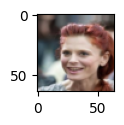

In [12]:
example = train_dataset[0][0]
plt.figure(figsize=(1,1))
plt.imshow(example.permute(1, 2, 0))
plt.show()

Let's define a function to plot the reconstruction of an image using the encoder and the decoder of a CCVAE.

In [13]:
def plot_image_recon(image, model):
  recon = model.reconstruct_img(image.cuda()).cpu().squeeze()
  recon = recon.permute(1,2,0)
  with torch.no_grad():
    plt.figure(figsize=(1,1))
    plt.imshow(recon)
    plt.show()

Define the parameters of the training.

In [14]:
img_shape = (3, 64, 64) #Define the shape of the image
cc_vae = CCVAE(45, len(CELEBA_EASY_LABELS), prior, True) #CCVAE Model
optim = torch.optim.Adam(cc_vae.parameters(), lr = 0.002) #Adam optimizer
number_epoch=20

Next cell executes the training loop. Inside the loop there is a tracking of the performance across epochs, and the different checkpoints of the model will be saved.

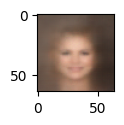

Epoch 0, Loss: 8928534.447265625, train accuracy: 0.832882285118103, Val accuracy: 0.8802837133407593


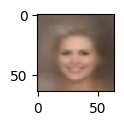

Epoch 1, Loss: 8445695.353515625, train accuracy: 0.8889418840408325, Val accuracy: 0.8891497850418091


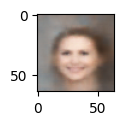

Epoch 2, Loss: 8362637.6201171875, train accuracy: 0.8962270021438599, Val accuracy: 0.8956855535507202


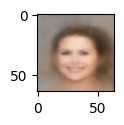

Epoch 3, Loss: 8320156.1279296875, train accuracy: 0.9006296396255493, Val accuracy: 0.8985298871994019


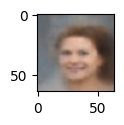

Epoch 4, Loss: 8305231.986328125, train accuracy: 0.9035540223121643, Val accuracy: 0.9001688361167908


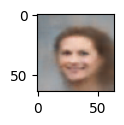

Epoch 5, Loss: 8284400.0498046875, train accuracy: 0.9062890410423279, Val accuracy: 0.9002994894981384


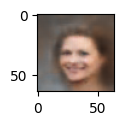

Epoch 6, Loss: 8274469.2568359375, train accuracy: 0.9086028933525085, Val accuracy: 0.9005492925643921


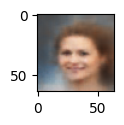

Epoch 7, Loss: 8257480.2236328125, train accuracy: 0.9099788069725037, Val accuracy: 0.9001248478889465


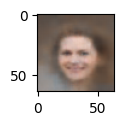

Epoch 8, Loss: 8272809.283203125, train accuracy: 0.9023292660713196, Val accuracy: 0.9000608921051025


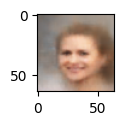

Epoch 9, Loss: 8292907.55078125, train accuracy: 0.9054571986198425, Val accuracy: 0.903602123260498


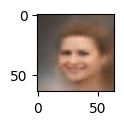

Epoch 10, Loss: 8277446.921875, train accuracy: 0.907020628452301, Val accuracy: 0.9020161032676697


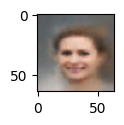

Epoch 11, Loss: 8285121.6337890625, train accuracy: 0.9068934917449951, Val accuracy: 0.9046627879142761


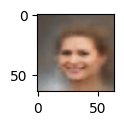

Epoch 12, Loss: 8281848.4130859375, train accuracy: 0.913577675819397, Val accuracy: 0.9030799865722656


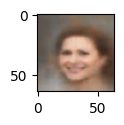

Epoch 13, Loss: 8289508.03515625, train accuracy: 0.9118411540985107, Val accuracy: 0.9026991128921509


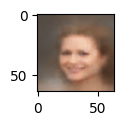

Epoch 14, Loss: 8290000.0400390625, train accuracy: 0.91361004114151, Val accuracy: 0.9012072086334229


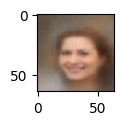

Epoch 15, Loss: 8289820.630859375, train accuracy: 0.9120345115661621, Val accuracy: 0.9008685946464539


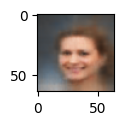

Epoch 16, Loss: 8311740.6259765625, train accuracy: 0.9141062498092651, Val accuracy: 0.9029459953308105


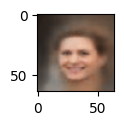

Epoch 17, Loss: 8332087.099609375, train accuracy: 0.9071422815322876, Val accuracy: 0.8682008981704712


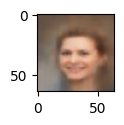

Epoch 18, Loss: 8349337.3447265625, train accuracy: 0.9080116748809814, Val accuracy: 0.900255024433136


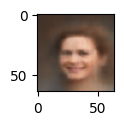

Epoch 19, Loss: 8357813.970703125, train accuracy: 0.9092413187026978, Val accuracy: 0.9002853035926819


In [15]:
# Define the path where checkpoints will be saved
path_to_save = '/content/drive/MyDrive/PGM/ccvae/checkpoints/final_experiment2'
os.makedirs(path_to_save, exist_ok=True)

best_accuracy = 0  # Initialize the best accuracy
train_losses=[]
train_acc=[]
val_acc=[]

for epoch in range(number_epoch):
    epoch_losses_sup = 0
    train_accuracy = 0.0

    # Train the model
    for batch_idx, (xs, ys) in enumerate(train_loader):
      cc_vae.train()
      xs = xs.cuda()
      ys = [y.float() for y in ys]
      ys = torch.stack(ys).T.cuda()
      loss = cc_vae.ccvae_loss_function(xs, ys)
      epoch_losses_sup += loss.detach().item()
      loss.backward()
      optim.step()
      optim.zero_grad()

      # Compute training accuracy
      batch_acc = cc_vae.classifier_acc(xs, ys)
      train_accuracy += batch_acc

    # Track training accuracy and loss
    train_accuracy = train_accuracy / len(train_loader)
    train_loss=epoch_losses_sup/len(train_loader)
    train_acc.append(train_accuracy.cpu())
    train_losses.append(train_loss)

    # Compute and track validation accuracy
    cc_vae.eval()
    validation_accuracy = 0.0
    for batch_idx, (xs, ys) in enumerate(valid_loader):
      xs = xs.cuda()
      ys = [y.float() for y in ys]
      ys = torch.stack(ys).T.cuda()
      batch_acc = cc_vae.classifier_acc(xs, ys)
      validation_accuracy += batch_acc

    validation_accuracy = validation_accuracy / len(valid_loader)
    val_acc.append(validation_accuracy.cpu())

    # Plot the reconstructed image for this epoch
    with torch.no_grad():
        plot_image_recon(example, cc_vae)

    # Print the epoch loss and the accuracies
    print(f"Epoch {epoch}, Loss: {epoch_losses_sup}, train accuracy: {train_accuracy}, Val accuracy: {validation_accuracy}")

    # Save the current state of the model.
    torch.save(cc_vae.state_dict(), os.path.join(path_to_save, f'checkpoint_epoch_{epoch}.pt'))

    # Check if this is the best accuracy so far and save if it is
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        torch.save(cc_vae.state_dict(), os.path.join(path_to_save, 'best_accuracy_checkpoint.pt'))

# Analyze training results

This cell visualizes the training and validation metrics over the course of training epochs.


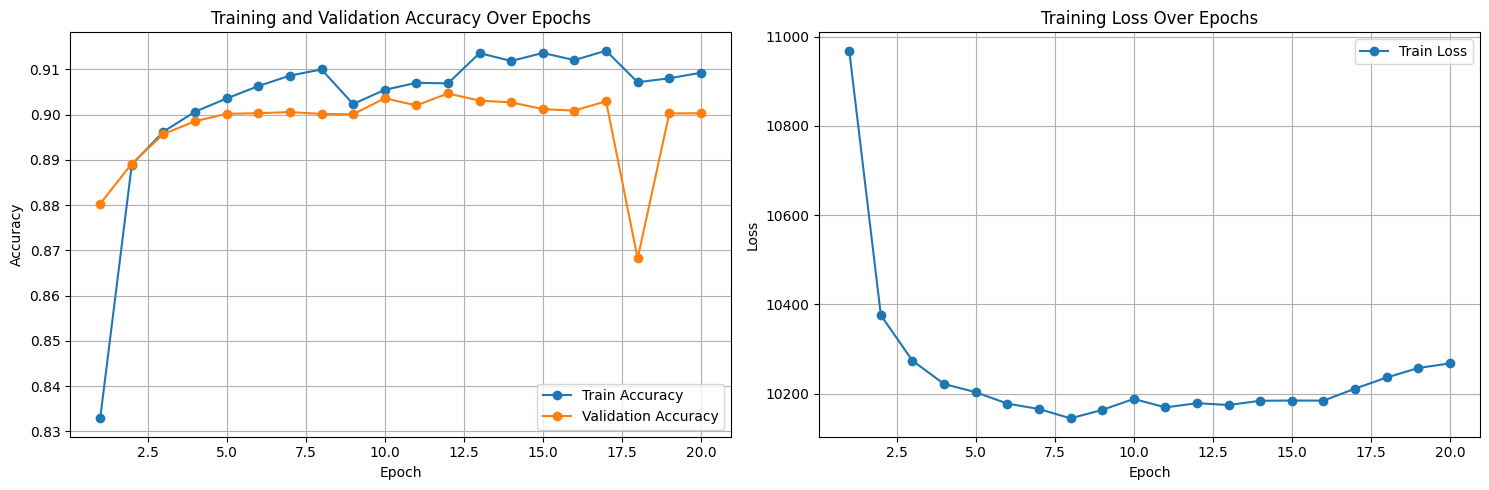

In [33]:
#Plotting
number_epoch=20

epochs = list(range(1, number_epoch+1))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axs[0].plot(epochs, train_acc, label='Train Accuracy', marker='o')
axs[0].plot(epochs, val_acc, label='Validation Accuracy', marker='o')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy Over Epochs')
axs[0].legend()
axs[0].grid(True)

# Plot train loss
axs[1].plot(epochs, train_losses, label='Train Loss', marker='o')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training Loss Over Epochs')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


Plot the confussion matrix for the classifier.

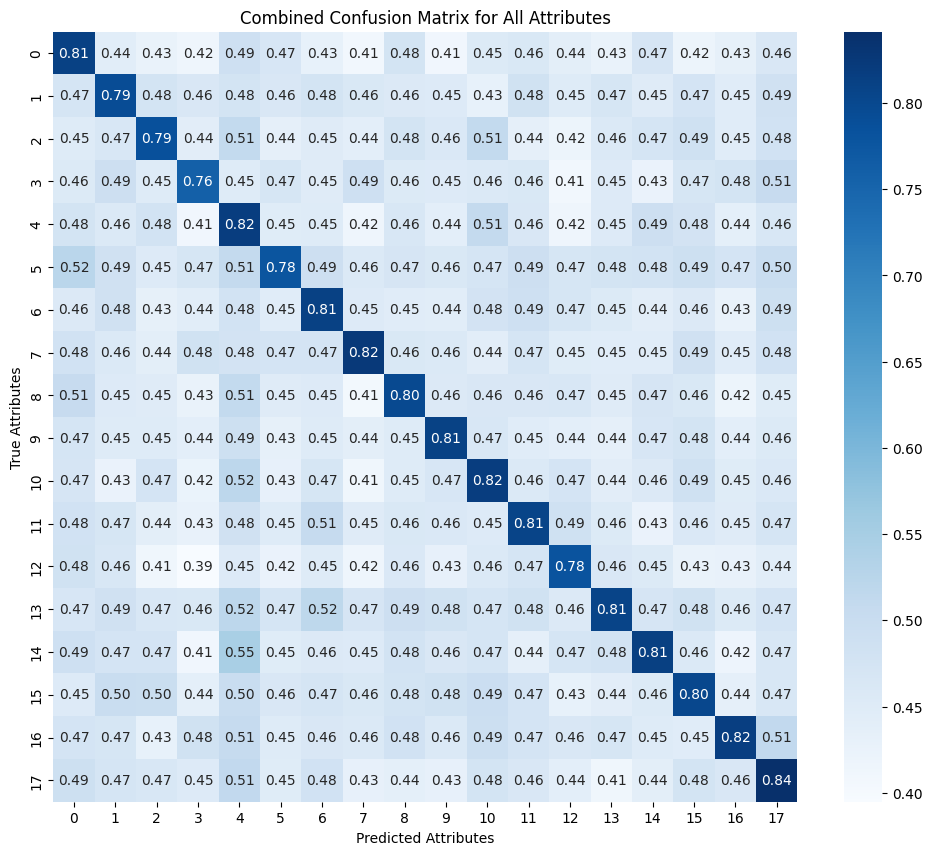

In [143]:

def generate_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []

    # Initialize a confusion matrix for each attribute (18x18 for 18 attributes)
    total_cm = np.zeros((num_classes, num_classes), dtype=int)
    class_counts = np.zeros(num_classes, dtype=int)

    with torch.no_grad():
        for xs, ys in data_loader:
            xs = xs.to(next(model.parameters()).device)

            ys = torch.vstack(ys)
            ys = ys.numpy()

            # Get predictions
            mean_q_z, variance_q_z = model.encoder(xs)

            z = dist.Normal(mean_q_z, variance_q_z).rsample()
            zc, _ = z.split([model.num_classes, model.z_dim - model.num_classes], dim=1)  # Split and take only the needed part
            logits = model.classifier(zc)
            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            preds = np.array(preds).astype(int).transpose()

            # Process each attribute
            for true_index in range(num_classes):
                class_counts[true_index] += np.sum(ys[:, true_index] == 1)
                for pred_index in range(num_classes):
                    total_cm[true_index, pred_index] += np.sum((ys[:, true_index] == 1) & (preds[:, pred_index] == 1))

    # Normalize the confusion matrix
    normalized_cm = total_cm / class_counts[:, None]

    # Plot the total confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted Attributes')
    plt.ylabel('True Attributes')
    plt.title('Combined Confusion Matrix for All Attributes')
    plt.show()

generate_confusion_matrix(cc_vae, valid_loader)


# Experiments

Next cell will load the model with the best validation accuracy.

In [38]:
cc_vae = CCVAE(45, len(CELEBA_EASY_LABELS), prior, True)
checkpoint_path = "/content/drive/MyDrive/PGM/ccvae/checkpoints/final_experiment2/best_accuracy_checkpoint.pt"
checkpoint = torch.load(checkpoint_path)
cc_vae.load_state_dict(checkpoint)
cc_vae.eval()

CCVAE(
  (encoder): CELEBAEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
      (9): ReLU(inplace=True)
      (10): View()
    )
    (locs): Linear(in_features=256, out_features=45, bias=True)
    (scales): Linear(in_features=256, out_features=45, bias=True)
  )
  (decoder): CELEBADecoder(
    (decoder): Sequential(
      (0): Linear(in_features=45, out_features=256, bias=True)
      (1): View()
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (4): ReLU(inpl

This function, `latent_walk_single_axis`, performs a latent space exploration along a single attribute axis for each class in the CelebA dataset. It visually demonstrates how changes in the latent space affect generated facial attributes.




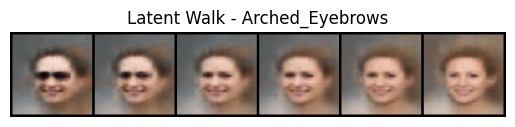

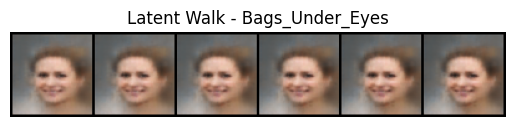

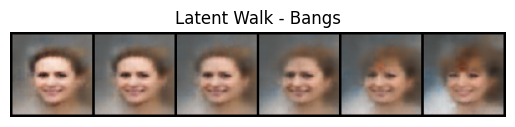

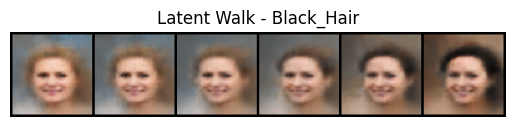

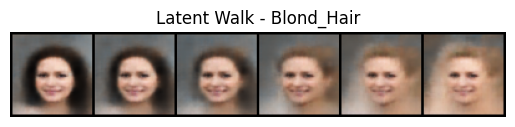

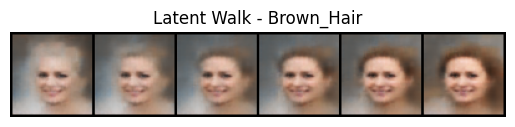

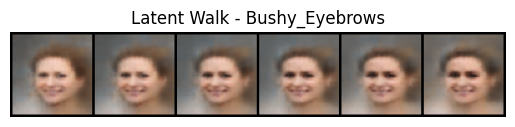

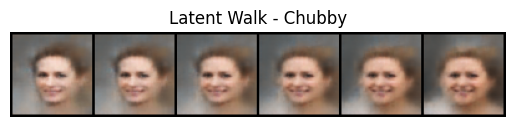

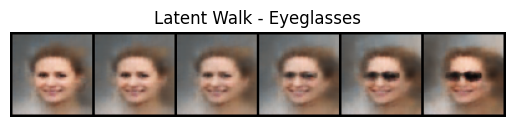

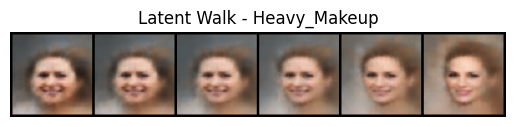

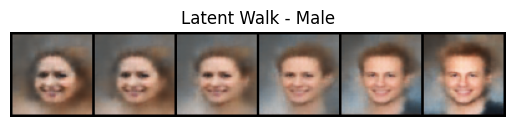

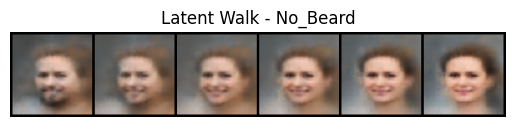

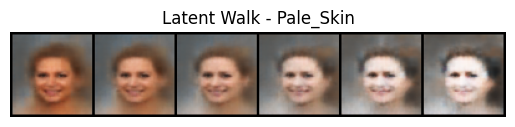

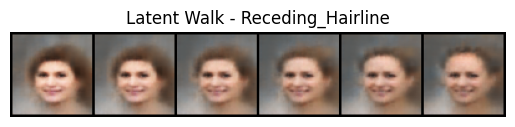

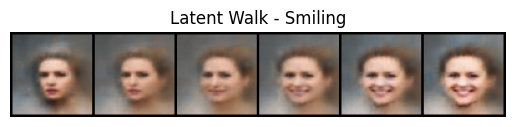

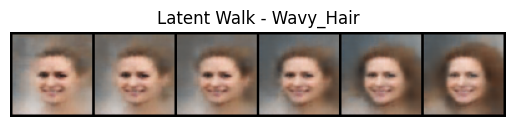

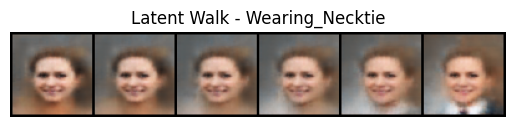

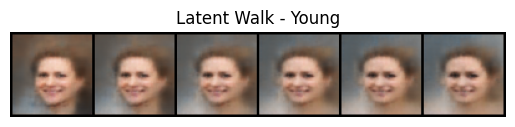

In [104]:

def latent_walk_single_axis(num_classes, im_shape, image, save_dir, model, num_steps=6, display_grid=True):
    device = next(model.parameters()).device
    mult = 5

    # Ensure the image is on the same device as the model
    image = image.to(device)

    # Sample from the latent space
    z_ = dist.Normal(*model.encoder(image.unsqueeze(0))).sample()[0]

    for i in range(num_classes):
        y = torch.zeros(1, num_classes).to(device)
        locs_false, scales_false = model.cond_prior(y)
        y[:, i].fill_(1.0)
        locs_true, scales_true = model.cond_prior(y)
        sign = torch.sign(locs_true[:, i] - locs_false[:, i])

        z_false_lim = (locs_false[:, i] - mult * sign * scales_false[:, i]).item()
        z_true_lim = (locs_true[:, i] + mult * sign * scales_true[:, i]).item()

        # Construct the range for the latent variable
        z_range = torch.linspace(z_false_lim, z_true_lim, num_steps)

        # Generate images for each step in the latent space
        imgs = []
        for z_val in z_range:
            z = z_.clone()
            z[i] = z_val
            img = model.decoder(z.unsqueeze(0)).view(*im_shape)
            imgs.append(img)

        # Create a grid of images
        grid = make_grid(imgs, nrow=num_steps)
        #save_image(grid, os.path.join(save_dir, f"latent_walk_{CELEBA_EASY_LABELS[i]}.png"))

        # Display the grid
        if display_grid:
            plt.imshow(to_pil_image(grid))
            plt.title(f"Latent Walk - {CELEBA_EASY_LABELS[i]}")
            plt.axis('off')
            plt.show()

num_classes = 18
img_shape = (3, 64, 64)  # Define the shape of the image
save_dir = "/content/final_experiment2"
latent_walk_single_axis(num_classes, img_shape, example, save_dir, cc_vae)


Next cell is use to generate a new image based on the selected attributes and a randomly generated style.

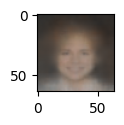

In [158]:

# Creates a binary vector representing the presence of specified attributes.
def create_label_vector(attributes, label_list):
    vector = torch.zeros(len(label_list))
    for attr in attributes:
        index = label_list.index(attr)
        vector[index] = 1
    return vector

'''example = train_dataset[0][0]
plt.figure(figsize=(1,1))
plt.imshow(example.permute(1, 2, 0))
plt.show()

def test( x):
        return dist.Normal(*cc_vae.encoder(x)).rsample()
z = test(example.cuda())[0]
zc, zs = z.split([18, 45 - 18])'''

# This function generates a new image based on specified attributes using the
# trained CCVAE model and selecting a random style.
def generate_new_image(model, attributes):
    # Create the label vector
    label_vector = create_label_vector(attributes, CELEBA_EASY_LABELS).cuda()

    # Sample from the latent space (assuming normal distribution)
    latent_vector = torch.randn(1, model.z_dim - len(CELEBA_EASY_LABELS))[0].cuda()

    # Concatenate the label vector with the latent vector
    combined_vector = torch.cat((label_vector, latent_vector)).cuda()

    # Generate the image
    with torch.no_grad():
        generated_image = model.decoder(combined_vector)

    # Plot the image
    plt.figure(figsize=(1,1))
    plt.imshow(generated_image.squeeze(0).permute(1, 2, 0).cpu())
    plt.show()

# Desired attributes
attributes = ['Smiling', 'Chubby', 'Male']  # No_Beard represents Female in this context
generate_new_image(cc_vae, attributes)

